Analysis for IndeLLM

In [2]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import data
overall = pd.read_csv("../Results/overall.csv")
alldata = pd.read_csv("../Data/Indel_curated.csv")

overall.head()
alldata.head()

,Unnamed: 0,Id_matching,Feature_x,Consequence_x,Protein_start,Protein_stop,wt,mut,seq,GeneID,...,DDD subset (n=151),CADD,CAPICE,FATHMM-indel,MutPredIndel,MutationTaster2021,PROVEAN,SIFT-indel,VEST-indel,VVP
0,0,0,ENST00000379198.5,inframe_insertion,4,NaN,L,LRRAWR,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,ENSG00000176022,...,No,12.37,0.073788,0.194999931,0.61176,Benign,-3.44,damaging,0.05,7.0
1,1,1,ENST00000379198.5,inframe_deletion,136,139.0,VLAM,V,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,ENSG00000176022,...,No,22.40,0.448487,0.912278105,0.71407,Deleterious,-11.00,damaging,0.23,98.0
2,2,2,ENST00000476993.2,inframe_deletion,61,69.0,VAPLPLGTG,V,MLPWTALGLALSLRLALARSGAERGPPASAPRGDLMFLLDSSASVS...,ENSG00000179403,...,No,21.60,0.570002,0.99589538,0.60790,Deleterious,-27.11,neutral,0.07,100.0
3,3,3,ENST00000404249.8,inframe_deletion,312,314.0,EEE,E,MGDEKDSWKVKTLDEILQEKKRRKEQEEKAEIKRLKNSDDRDSKRD...,ENSG00000008128,...,No,15.81,0.005563,0.466641233,0.11935,Benign,-2.76,neutral,0.10,15.0
4,4,4,ENST00000341426.9,inframe_deletion,445,446.0,EG,G,MEMEQEKMTMNKELSPDAAAYCCSACHGDETWSYNHPIRGRAKSRS...,ENSG00000008130,...,No,6.09,0.001876,0.008217187,0.38066,Benign,-1.90,damaging,0.29,95.0


In [3]:
import numpy as np

#Add indel type (insertion or deletion) info
overall['indel'] = overall.apply(lambda row: 'deletion' if row['length_mut'] < row['length_wt'] else 'insertion', axis=1)

#Add indel length 
overall['length_indel'] = overall.apply(lambda row: row['length_wt'] - row['length_mut'] if row['indel'] == 'deletion' else row['length_mut'] - row['length_wt'], axis=1) 

#Add difference of fitness (positive value positive effect, negative value negative effect)
overall['dif_evo'] = overall['evo_mut'] - overall['evo_wt']
overall['dif_fit'] = overall['fit_mut'] - overall['fit_wt']

#Add a cleaned up labels info
overall['labels_cleaned'] = np.where(overall['label'].str.contains('benign', case=False, na=False), 
                                'Benign', 
                                np.where(overall['label'].str.contains('pathogenic', case=False, na=False), 
                                         'Pathogenic', 
                                         np.nan))

overall.head()

,pair_id,length_mut,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,label,indel,length_indel,dif_evo,dif_fit,labels_cleaned
0,0,334,329,300.976887,295.771454,183.474468,181.478358,Benign/Likely benign,insertion,5,5.205434,1.996110,Benign
1,1,326,329,289.070291,295.771454,175.395118,181.483721,Pathogenic,deletion,3,-6.701162,-6.088603,Pathogenic
2,2,437,445,394.023689,407.087317,202.841284,211.450276,Likely pathogenic,deletion,8,-13.063628,-8.608993,Pathogenic
3,4,445,446,407.261862,408.398288,197.364461,198.448622,likely benign,deletion,1,-1.136426,-1.084161,Benign
4,5,339,340,279.895415,282.956223,169.600709,175.565114,Pathogenic,deletion,1,-3.060808,-5.964405,Pathogenic


In [4]:
#Calculating the average dif values per bening and pathogenic
evomeanpath = overall[overall['labels_cleaned'] == 'Pathogenic']['dif_evo'].mean()
evomeanbeg = overall[overall['labels_cleaned'] == 'Benign']['dif_evo'].mean()

fitmeanpath = overall[overall['labels_cleaned'] == 'Pathogenic']['dif_fit'].mean()
fitmeanbeg = overall[overall['labels_cleaned'] == 'Benign']['dif_fit'].mean()

print("Evo Model, mean for pathogenic indels:", evomeanpath)
print("Evo Model, mean for begign indels:", evomeanbeg)
print("Fit Model, mean for pathogenic indels:", fitmeanpath)
print("Fit Model, mean for benign indels", fitmeanbeg)

Evo Model, mean for pathogenic indels: -3.6320691402532517
Evo Model, mean for begign indels: -1.2970779419085199
Fit Model, mean for pathogenic indels: -3.4223875154260623
Fit Model, mean for benign indels -0.4614182559092736


Text(0, 0.5, 'Difference Evo Model')

Text(0.5, 0, 'Ids of indels')

Text(0.5, 1.0, 'Evo difference per indel, colored by true labels')

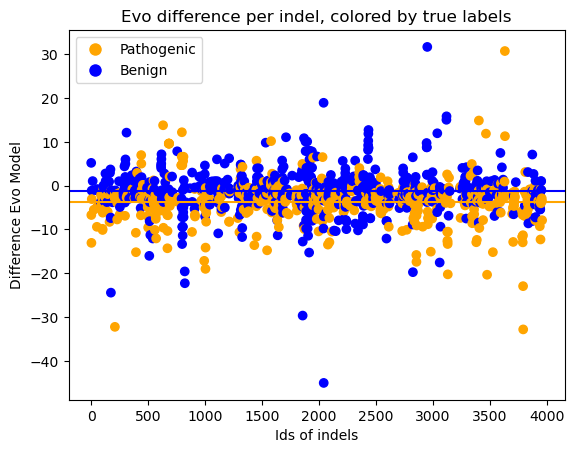

Text(0, 0.5, 'Difference Fit Model')

Text(0.5, 0, 'Ids of indels')

Text(0.5, 1.0, 'Fit difference per indel, colored by true labels')

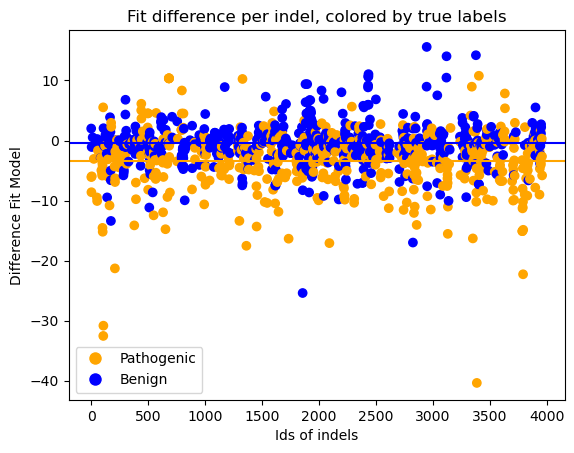

Text(0.5, 0, 'fit')

Text(0, 0.5, 'evo')

Text(0.5, 1.0, 'Comapring the Fit and Evo difference scores, colored by true labels')

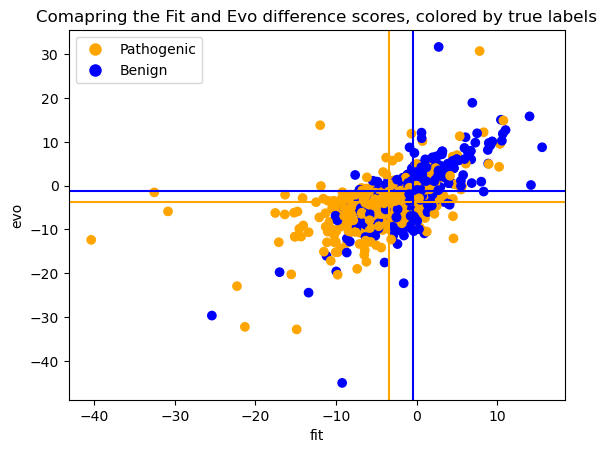

In [5]:
import matplotlib.pyplot as plt

#Creating colors for labels
color_map = {'Pathogenic': 'orange', 'Benign': 'blue'}
colors = overall['labels_cleaned'].map(color_map)
legend_labels = {label: color for label, color in color_map.items() if label in overall['labels_cleaned'].unique()}
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
           for label, color in legend_labels.items()]

#Plotting evo scores
plt.scatter(overall['pair_id'],overall['dif_evo'], c=colors)
plt.ylabel('Difference Evo Model')
plt.xlabel('Ids of indels')
plt.title('Evo difference per indel, colored by true labels')
plt.axhline(y=evomeanpath, color = 'orange')
plt.axhline(y=evomeanbeg, color = 'blue')
plt.legend(handles=handles, loc = 'best')
plt.show()

#Plotting fit scores
plt.scatter(overall['pair_id'],overall['dif_fit'], c=colors)
plt.ylabel('Difference Fit Model')
plt.xlabel('Ids of indels')
plt.title('Fit difference per indel, colored by true labels')
plt.axhline(y=fitmeanpath, color = 'orange')
plt.axhline(y=fitmeanbeg, color = 'blue')
plt.legend(handles=handles, loc = 'best')
plt.show()

#Plotting evo and fit scores together
plt.scatter(overall['dif_fit'], overall['dif_evo'], c=colors)
plt.xlabel('fit')
plt.ylabel('evo')
plt.title('Comapring the Fit and Evo difference scores, colored by true labels')
plt.axhline(y=evomeanpath, color = 'orange')
plt.axhline(y=evomeanbeg, color = 'blue')
plt.axvline(x=fitmeanpath, color = 'orange')
plt.axvline(x=fitmeanbeg, color = 'blue')
plt.legend(handles=handles, loc = 'best')
plt.show()

In [6]:
#identifying the low scoring benign
fit_under10 = overall.loc[(overall['labels_cleaned'] == 'Benign') & (overall['dif_fit'] < -10)]
print(fit_under10)

#Partly explained by indel size. Removed indels larger than 10bp
overall_small = overall[overall['length_indel'] < 11]

     pair_id  length_mut  length_wt     evo_mut      evo_wt     fit_mut  \
46       173          65         89   50.657067   75.090821   11.368289   
128      510         104        120   87.960535  103.989124   23.302300   
484     1856         387        419  324.009807  353.677322  132.405266   
817     2824         403        423  330.160794  349.916364  140.703721   
906     3137         457        464  368.514415  375.380665  162.916523   

         fit_wt          label     indel  length_indel    dif_evo    dif_fit  \
46    24.760969  likely benign  deletion            24 -24.433754 -13.392679   
128   34.468675  likely benign  deletion            16 -16.028588 -11.166375   
484  157.797233  likely benign  deletion            32 -29.667515 -25.391967   
817  157.693906  likely benign  deletion            20 -19.755570 -16.990184   
906  172.963818  likely benign  deletion             7  -6.866250 -10.047295   

    labels_cleaned  
46          Benign  
128         Benign  
484  

In [7]:
#Re-calculate a new mean for the small indels
evomeanpathsmall = overall_small[overall_small['labels_cleaned'] == 'Pathogenic']['dif_evo'].mean()
evomeanbegsmall = overall_small[overall_small['labels_cleaned'] == 'Benign']['dif_evo'].mean()
fitmeanpathsmall = overall_small[overall_small['labels_cleaned'] == 'Pathogenic']['dif_fit'].mean()
fitmeanbegsmall = overall_small[overall_small['labels_cleaned'] == 'Benign']['dif_fit'].mean()

#Compare the new means
print("Evo Model, mean for pathogenic indels:", evomeanpath)
print("Evo Model, mean for small pathogenic indels:", evomeanpathsmall)
print("Evo Model, mean for benign indels:", evomeanbeg)
print("Evo Model, mean for small benign indels:", evomeanbegsmall)

print("Fit Model, mean for pathogenic indels:", fitmeanpath)
print("Fit Model, mean for small pathogenic indels:", fitmeanpathsmall)
print("Fit Model, mean for benign indels", fitmeanbeg)
print("Fit Model, mean for small benign indels", fitmeanbegsmall)

Evo Model, mean for pathogenic indels: -3.6320691402532517
Evo Model, mean for small pathogenic indels: -3.624060709764012
Evo Model, mean for benign indels: -1.2970779419085199
Evo Model, mean for small benign indels: -1.0280902817331419
Fit Model, mean for pathogenic indels: -3.4223875154260623
Fit Model, mean for small pathogenic indels: -3.3614013737602804
Fit Model, mean for benign indels -0.4614182559092736
Fit Model, mean for small benign indels -0.359733203802016


Text(0, 0.5, 'Difference Evo Model')

Text(0.5, 0, 'Ids for indels')

Text(0.5, 1.0, 'Evo difference per small indel, colored by true labels')

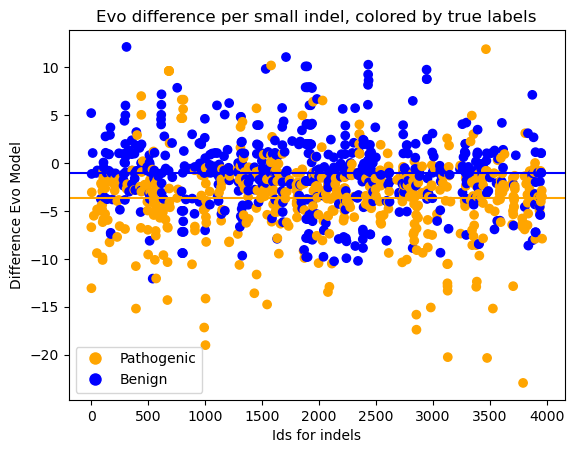

Text(0, 0.5, 'Difference Fit Model ')

Text(0.5, 0, 'Ids for indels')

Text(0.5, 1.0, 'Fit difference per small indel, colored by true labels')

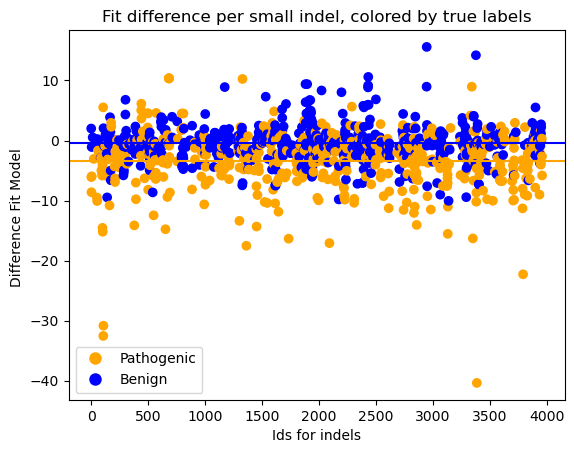

Text(0.5, 0, 'Difference Fit Model')

Text(0, 0.5, 'Difference Evo Model')

Text(0.5, 1.0, 'Comapring the Fit and Evo difference scores for small indels, colored by true labels ')

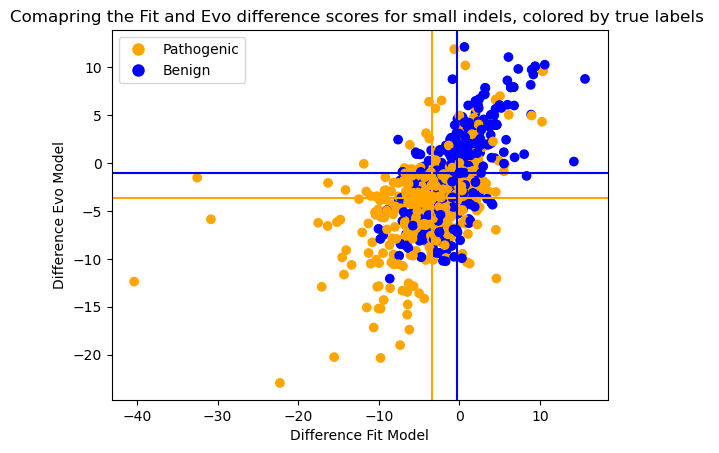

<Axes: xlabel='labels_cleaned', ylabel='dif_evo'>

Text(0.5, 1.0, 'Evo Model')

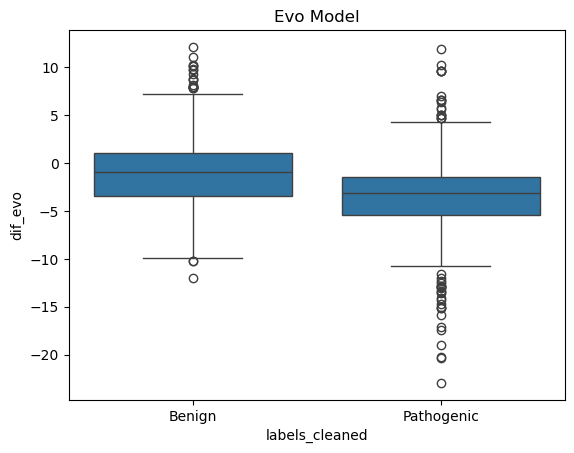

<Axes: xlabel='labels_cleaned', ylabel='dif_fit'>

Text(0.5, 1.0, 'Fit Model')

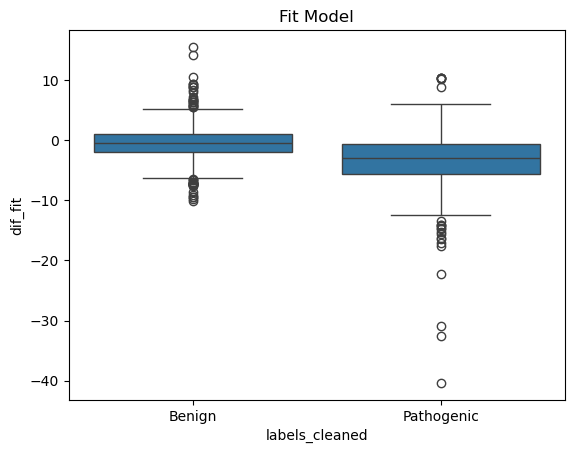

In [8]:
import seaborn as sns
#Plotting for only indels of 10bp or less

#Creating a new colormap for the labels
colors_small = overall_small['labels_cleaned'].map(color_map)
legend_labels_small = {label: color for label, color in color_map.items() if label in overall_small['labels_cleaned'].unique()}
handles_small = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
           for label, color in legend_labels_small.items()]

#Plotting evo scores for small indels
plt.scatter(overall_small['pair_id'],overall_small['dif_evo'], c=colors_small)
plt.ylabel('Difference Evo Model')
plt.xlabel('Ids for indels')
plt.title('Evo difference per small indel, colored by true labels')
plt.axhline(y=evomeanpathsmall, color = 'orange')
plt.axhline(y=evomeanbegsmall, color = 'blue')
plt.legend(handles=handles_small, loc = 'best')
plt.show()

#Plotting fit scores for small indels
plt.scatter(overall_small['pair_id'],overall_small['dif_fit'], c=colors_small)
plt.ylabel('Difference Fit Model ')
plt.xlabel('Ids for indels')
plt.title('Fit difference per small indel, colored by true labels')
plt.axhline(y=fitmeanpathsmall, color = 'orange')
plt.axhline(y=fitmeanbegsmall, color = 'blue')
plt.legend(handles=handles_small, loc = 'best')
plt.show()

#Plotting fit and evo scores for small indels
plt.scatter(overall_small['dif_fit'], overall_small['dif_evo'], c=colors_small)
plt.xlabel('Difference Fit Model')
plt.ylabel('Difference Evo Model')
plt.title('Comapring the Fit and Evo difference scores for small indels, colored by true labels ')
plt.axhline(y=evomeanpathsmall, color = 'orange')
plt.axhline(y=evomeanbegsmall, color = 'blue')
plt.axvline(x=fitmeanpathsmall, color = 'orange')
plt.axvline(x=fitmeanbegsmall, color = 'blue')
plt.legend(handles=handles_small, loc = 'best')
plt.show()

#Also included boxplots
sns.boxplot(x = overall_small['labels_cleaned'], y = overall_small['dif_evo'])
plt.title('Evo Model')
plt.show()

sns.boxplot(x = overall_small['labels_cleaned'], y = overall_small['dif_fit'])
plt.title('Fit Model')
plt.show()

F1 score Evo small indels: 0.6646884272997032
F1 score Fit small indels: 0.7087719298245614


/tmp/ipykernel_2964900/930163297.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_small['labels_binary'] = overall_small.apply(lambda row: 0 if row['labels_cleaned'] == 'Pathogenic' else 1, axis=1)


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

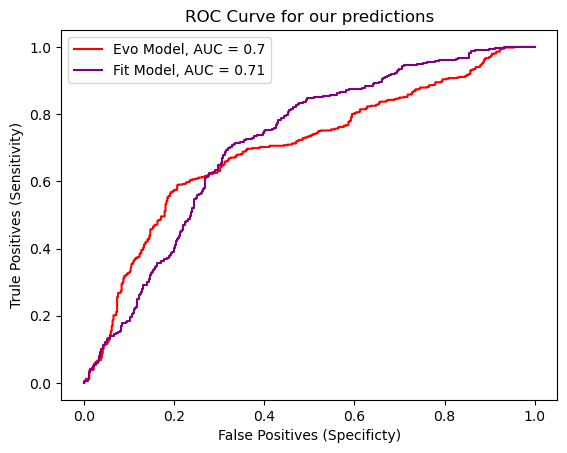

In [53]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score

#Turing the true lables into binary
overall_small['labels_binary'] = overall_small.apply(lambda row: 0 if row['labels_cleaned'] == 'Pathogenic' else 1, axis=1)

#Extrating Arrays
truelabels = overall_small['labels_binary'].values
pred_evo = overall_small['dif_evo'].values
pred_fit = overall_small['dif_fit'].values

#Calculating FP, TN and thresholds for Evo and Fit
fpr_evo, tpr_evo, thersholds_evo = metrics.roc_curve(truelabels, pred_evo)
roc_auc_evo = round(metrics.auc(fpr_evo, tpr_evo), 2)

fpr_fit, tpr_fit, thersholds_fit = metrics.roc_curve(truelabels, pred_fit)
roc_auc_fit = round(metrics.auc(fpr_fit, tpr_fit), 2)

#Using the threshold to create a binary table of the predicted values
#Find the best threshold
tresh_evo = thersholds_evo[np.argmax(tpr_evo - fpr_evo)]
tresh_fit = thersholds_fit[np.argmax(tpr_fit - fpr_fit)]

#Converting the continous predictions into binary
pred_evo_bin = [1 if x >= tresh_evo else 0 for x in pred_evo]
pred_fit_bin = [1 if x >= tresh_fit else 0 for x in pred_fit]

#Calculating F1 score
f1_evo = f1_score(truelabels, pred_evo_bin, average = 'binary')
f1_fit = f1_score(truelabels, pred_fit_bin, average = 'binary')

print("F1 score Evo small indels:", f1_evo)
print("F1 score Fit small indels:", f1_fit)

#Plotting the Evo and Fit AUC 
plt.plot(fpr_evo, tpr_evo, label = "Evo Model, AUC = "+str(roc_auc_evo), color = "red")
plt.plot(fpr_fit, tpr_fit, label = "Fit Model, AUC = "+str(roc_auc_fit), color = "purple")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

F1 score Evo small indels: 0.6646884272997032
F1 score Fit small indels: 0.7087719298245614
F1 score Combined small indels: 0.6963788300835655


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions combined')

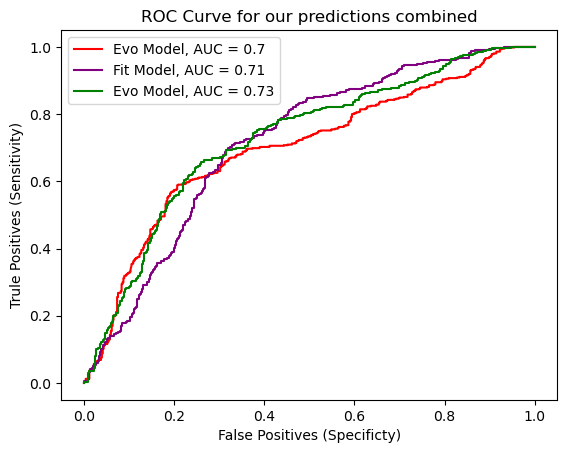

In [55]:
#Try to add the methods together

#Extrating Arrays
truelabels = overall_small['labels_binary'].values
pred_combined = (pred_evo + pred_fit) / 2

#Calculating FP, TN and thresholds
fpr_combined, tpr_combined, thersholds_combined = metrics.roc_curve(truelabels, pred_combined)
roc_auc_combined = round(metrics.auc(fpr_combined, tpr_combined), 2)

#Using the threshold to create a binary table of the predicted values
#Find the best threshold
tresh_combined = thersholds_combined[np.argmax(tpr_combined - fpr_combined)]

#Converting the continous predictions into binary
pred_combined_bin = [1 if x >= tresh_combined else 0 for x in pred_combined]

#Calculating F1 score
f1_combined = f1_score(truelabels, pred_combined_bin, average = 'binary')

print("F1 score Evo small indels:", f1_evo)
print("F1 score Fit small indels:", f1_fit)
print("F1 score Combined small indels:", f1_combined)


#Plotting the Evo and Fit AUC 
plt.plot(fpr_evo, tpr_evo, label = "Evo Model, AUC = "+str(roc_auc_evo), color = "red")
plt.plot(fpr_fit, tpr_fit, label = "Fit Model, AUC = "+str(roc_auc_fit), color = "purple")
plt.plot(fpr_combined, tpr_combined, label = "Evo Model, AUC = "+str(roc_auc_combined), color = "green")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions combined")
plt.legend(loc = 'best')
plt.show()

In [40]:
#Compare to the other indel predictors

#Extract the IDs that we kept from the original dataset, and clean up labels
keptlabels = alldata[alldata['Id_matching'].isin(overall_small['pair_id'])]
keptlabels['labels_cleaned'] = np.where(keptlabels['Classification'].str.contains('benign', case=False, na=False), 
                                'Benign', 
                                np.where(keptlabels['Classification'].str.contains('pathogenic', case=False, na=False), 
                                         'Pathogenic', 
                                         np.nan))

keptlabels['labels_binary'] = keptlabels.apply(lambda row: 0 if row['labels_cleaned'] == 'Pathogenic' else 1, axis=1)
truelabels = overall_small['labels_binary'].values


/tmp/ipykernel_2964900/1168156627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keptlabels['labels_cleaned'] = np.where(keptlabels['Classification'].str.contains('benign', case=False, na=False),
/tmp/ipykernel_2964900/1168156627.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keptlabels['labels_binary'] = keptlabels.apply(lambda row: 0 if row['labels_cleaned'] == 'Pathogenic' else 1, axis=1)


VEST-Indel: Douville et al. 2015 (https://onlinelibrary.wiley.com/doi/full/10.1002/humu.22911)

From method section: 

A curated set of in-frame and frameshift indels (microdeletions and microinsertions) of ≤20 base-pairs in length, annotated as being pathogenic from publications in the biomedical literature, was downloaded from Human Gene Mutation Database [Stenson et al., 2014] (2014v.3). Only high-confidence annotations with the “DM” designation were included. A second curated set of in-frame and frameshift indels was downloaded from the NCBI ClinVar database on August 7, 2014. Only entries annotated as “likely pathogenic” (Clinical Significance 4) or “pathogenic” (Clinical Significance 5) and not annotated as a somatic mutation were included. Any entry from ClinVar that was also present in HGMD was removed from the ClinVar set. Annotated in-frame and frameshift variants were downloaded from the Exome Variant Server using (ESP6500SI-V2-SSA137) [Fu et al., 2013] and from the 1000 Genomes Project Phase 3 (ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/) [Clarke et al., 2012]. To increase the likelihood that variants from the Exome Variant Server and 1000 Genomes Project were benign common polymorphisms, and to retain sufficient variants for our training set, we only used variants with a minor allele frequency (MAF) ≥0.01 and occurring in either African individuals or those of African ancestry. In ESP600, these were identified as “African-American” and in 1000G as the AFR superpopulation comprising YRI (Yoruba in Ibadan, Nigeria), LWK (luhya in Webuye, Kenya), GWD (Gambian in Western Divisions in the Gambia), MSL (Mende in Sierra Leone), ESN (Esan in Nigeria), ASW (Americans of African ancestry in SW USA), and ACG (African Caribbeans in Barbados). The other populations represented in ESP6500 and 1000G are believed to have experienced severe bottlenecks in recent history, and hence individuals from these populations may harbor potentially pathogenic variants at higher MAF than individuals of African ancestry [Lohmueller et al., 2008; MacArthur and Tyler-Smith, 2010; Ng et al., 2008; Hu and Ng, 2012]. A curated set of putatively benign in-frame and frameshift indels, derived from pairwise genome alignments of human and cow, dog, horse, chimpanzee, rhesus macaque, and rat, was generously provided to us by Pauline Ng and Jing Hu. This set had been previously used to train their SIFT-indel classifier [Hu and Ng, 2012; Hu and Ng, 2013]. Additional background information about these data sets, including probability densities for indel length and MAF, are shown in Supp. Figure S1.

,Unnamed: 0,Id_matching,Protein_start,Protein_stop,Unnamed: 0_y,start-b38,stop-b38,CADD,CAPICE,MutPredIndel,PROVEAN,VEST-indel,VVP,labels_binary
count,1033.000000,1033.000000,1033.000000,667.000000,0.0,1.033000e+03,1.033000e+03,1032.000000,1032.000000,1031.000000,976.000000,1033.000000,1032.000000,1033.000000
mean,1922.917715,1990.513069,172.350436,174.701649,NaN,7.021315e+07,7.021315e+07,15.950965,0.312396,0.480251,-6.766834,0.519700,65.492248,0.513069
std,1057.217796,1098.302591,116.427054,118.040964,NaN,5.786142e+07,5.786142e+07,5.676279,0.378466,0.216734,8.311821,0.362348,39.988746,0.500071
min,0.000000,0.000000,1.000000,2.000000,NaN,1.685300e+04,1.685400e+04,0.072000,0.000005,0.067692,-52.720000,0.000000,0.000000,0.000000
25%,1090.000000,1124.000000,70.000000,71.000000,NaN,2.369588e+07,2.369588e+07,13.002500,0.004748,0.294910,-11.582500,0.170000,14.750000,0.000000
50%,1886.000000,1945.000000,161.000000,163.000000,NaN,5.231796e+07,5.231796e+07,17.545000,0.078223,0.489930,-3.975000,0.460000,90.000000,1.000000
75%,2751.000000,2847.000000,251.000000,255.500000,NaN,1.048565e+08,1.048565e+08,20.400000,0.681527,0.630405,-0.460000,0.920000,98.000000,1.000000
max,3814.000000,3958.000000,490.000000,479.000000,NaN,2.485746e+08,2.485746e+08,24.800000,0.999197,0.913410,22.510000,1.000000,100.000000,1.000000


Text(0.5, 1.0, 'VEST predictor results')

<Axes: title={'center': 'VEST predictor results'}, xlabel='labels_cleaned', ylabel='VEST-indel'>

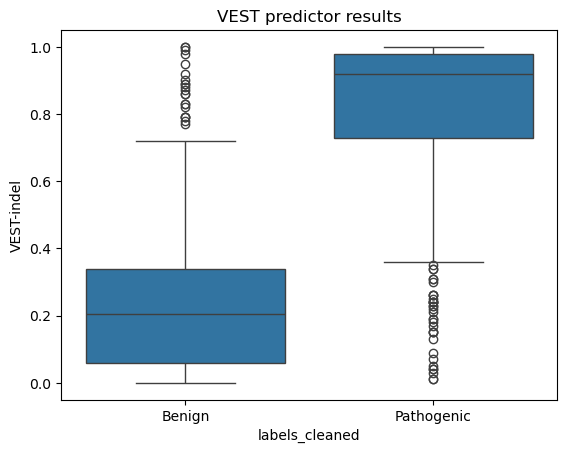

F1 score Combined/IndeLLM small indels: 0.6963788300835655
F1 score VEST small indels: 0.8721649484536083


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

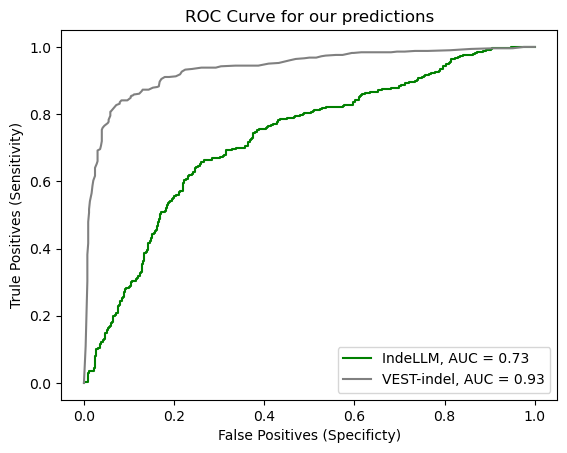

In [63]:
#Some of the columns in VEST contain no prediction, so filer the dataset
filtered_VEST = keptlabels.dropna(subset=['VEST-indel'])
pred_VEST = filtered_VEST['VEST-indel'].values
truelabels_VEST = filtered_VEST['labels_binary'].values

filtered_VEST.describe()

#Boxplot of VEST
plt.title('VEST predictor results')
sns.boxplot(x = filtered_VEST['labels_cleaned'], y = filtered_VEST['VEST-indel'])
plt.show()

#The VEST predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_VEST -= 1
truelabels_VEST = np.abs(truelabels_VEST) 

#Calculating FP, TN and thresholds
fpr_VEST, tpr_VEST, thersholds_VEST = metrics.roc_curve(truelabels_VEST, pred_VEST)
roc_auc_VEST = round(metrics.auc(fpr_VEST, tpr_VEST), 2)

#Calculating F1 score
tresh_VEST = thersholds_VEST[np.argmax(tpr_VEST - fpr_VEST)]
pred_VEST_bin = [1 if x >= tresh_VEST else 0 for x in pred_VEST]
f1_VEST = f1_score(truelabels_VEST, pred_VEST_bin, average = 'binary')

print("F1 score Combined/IndeLLM small indels:", f1_combined)
print("F1 score VEST small indels:", f1_VEST)

#Plotting the Evo, Fit and VEST AUC 
plt.plot(fpr_combined, tpr_combined, label = "IndeLLM, AUC = "+str(roc_auc_combined), color = "green")
plt.plot(fpr_VEST, tpr_VEST, label = "VEST-indel, AUC = "+str(roc_auc_VEST), color = "grey")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()
